In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import numpy as np


# Choose device, mps for macbook m1
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")


Using device: mps


In [2]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)



Files already downloaded and verified
Files already downloaded and verified


In [3]:

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [33]:
class SimpleResNet(nn.Module):
    def __init__(self):
        super(SimpleResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)

        self.resblock1_1 = ResidualBlock(16, 16, stride=1)
        self.resblock1_2 = ResidualBlock(16, 16, stride=1)
        self.resblock2_1 = ResidualBlock(16, 32, stride=2)
        self.resblock2_2 = ResidualBlock(32, 32, stride=1)
        self.resblock3_1 = ResidualBlock(32, 64, stride=2)
        self.resblock3_2 = ResidualBlock(64, 64, stride=1)

        self.fc1 = nn.Linear(64 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        x = self.resblock1_1(x)
        x = self.resblock1_2(x)
        x = self.resblock2_1(x)
        x = self.resblock2_2(x)
        x = self.resblock3_1(x)
        x = self.resblock3_2(x)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
model = SimpleResNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

num_epochs = 100
best_acc = 0
train_losses, test_losses, lrs = [], [], []

os.makedirs("checkpoints", exist_ok=True)

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0,0,0

    #Training
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs,1)
        total += labels.size(0)
        correct += (pred==labels).sum().item()

    train_loss = running_loss/len(trainloader)
    train_acc = 100*correct/total
    train_losses.append(train_loss)

    #Testing
    model.eval()
    test_loss, test_correct, test_total = 0,0,0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _,pred = torch.max(outputs,1)
            test_total += labels.size(0)
            test_correct += (pred==labels).sum().item()
    test_loss /= len(testloader)
    test_acc = 100*test_correct/test_total
    test_losses.append(test_loss)

    #Learning rate
    current_lr = optimizer.param_groups[0]['lr']
    lrs.append(current_lr)
    scheduler.step()

    #Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), f"checkpoints/best_model_epoch{epoch+1}_acc{best_acc:.2f}.pth")

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"LR: {current_lr:.4f} | "
          f"Train Loss: {train_loss:.3f} | Test Loss: {test_loss:.3f} | "
          f"Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

print(f"Training complete. Best test accuracy: {best_acc:.2f}%")

Epoch [1/50] | LR: 0.1000 | Train Loss: 1.928 | Test Loss: 1.736 | Train Acc: 25.44% | Test Acc: 34.99%
Epoch [2/50] | LR: 0.1000 | Train Loss: 1.610 | Test Loss: 1.716 | Train Acc: 40.30% | Test Acc: 38.95%
Epoch [3/50] | LR: 0.1000 | Train Loss: 1.432 | Test Loss: 1.390 | Train Acc: 48.15% | Test Acc: 51.78%
Epoch [4/50] | LR: 0.1000 | Train Loss: 1.308 | Test Loss: 1.639 | Train Acc: 53.61% | Test Acc: 44.16%
Epoch [5/50] | LR: 0.1000 | Train Loss: 1.235 | Test Loss: 1.141 | Train Acc: 56.39% | Test Acc: 59.10%
Epoch [6/50] | LR: 0.1000 | Train Loss: 1.172 | Test Loss: 1.054 | Train Acc: 59.02% | Test Acc: 63.49%
Epoch [7/50] | LR: 0.1000 | Train Loss: 1.136 | Test Loss: 1.251 | Train Acc: 60.57% | Test Acc: 56.96%
Epoch [8/50] | LR: 0.1000 | Train Loss: 1.099 | Test Loss: 1.049 | Train Acc: 61.71% | Test Acc: 64.30%
Epoch [9/50] | LR: 0.1000 | Train Loss: 1.071 | Test Loss: 1.216 | Train Acc: 63.09% | Test Acc: 60.82%
Epoch [10/50] | LR: 0.1000 | Train Loss: 1.040 | Test Loss: 1.06

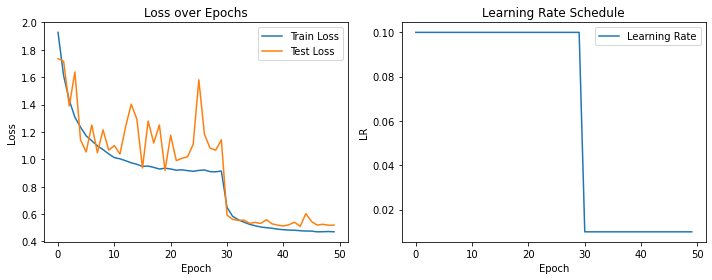

In [6]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(lrs, label='Learning Rate')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch'); plt.ylabel('LR'); plt.legend()
plt.tight_layout()
plt.show()

In [12]:
class ConvBlock(nn.Module):
    def __init__(self, num_conv_layers=3):
        super().__init__()
        layers = []
        in_channels = 3
        out_channels_list = [32, 64, 128, 256, 512, 1024, 2048]  # just an example

        for i in range(num_conv_layers):
            out_channels = out_channels_list[i]
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
            in_channels = out_channels
        
        self.conv_layers = nn.Sequential(*layers)
        self.pool = nn.MaxPool2d(2, 2)
        fc_input_size = out_channels_list[num_conv_layers-1] * 16 * 16  # assuming 32x32 input
        self.fc1 = nn.Linear(fc_input_size, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
d = 3 #depth
model = ConvBlock(num_conv_layers=d).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

num_epochs = 100
best_acc = 0
train_losses, test_losses, lrs = [], [], []

os.makedirs("checkpoints", exist_ok=True)

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0,0,0

    #Training
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs,1)
        total += labels.size(0)
        correct += (pred==labels).sum().item()

    train_loss = running_loss/len(trainloader)
    train_acc = 100*correct/total
    train_losses.append(train_loss)

    #Testing
    model.eval()
    test_loss, test_correct, test_total = 0,0,0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _,pred = torch.max(outputs,1)
            test_total += labels.size(0)
            test_correct += (pred==labels).sum().item()
    test_loss /= len(testloader)
    test_acc = 100*test_correct/test_total
    test_losses.append(test_loss)

    #Learning rate
    current_lr = optimizer.param_groups[0]['lr']
    lrs.append(current_lr)
    scheduler.step()

    #Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), f"checkpoints/best_model_epoch{epoch+1}_acc{best_acc:.2f}.pth")

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"LR: {current_lr:.4f} | "
          f"Train Loss: {train_loss:.3f} | Test Loss: {test_loss:.3f} | "
          f"Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

print(f"Training complete. Best test accuracy: {best_acc:.2f}%")

Epoch [1/100] | LR: 0.1000 | Train Loss: 2.291 | Test Loss: 1.966 | Train Acc: 19.58% | Test Acc: 26.95%
Epoch [2/100] | LR: 0.1000 | Train Loss: 1.999 | Test Loss: 1.880 | Train Acc: 24.06% | Test Acc: 28.25%
Epoch [3/100] | LR: 0.1000 | Train Loss: 1.943 | Test Loss: 1.750 | Train Acc: 25.51% | Test Acc: 32.65%
Epoch [4/100] | LR: 0.1000 | Train Loss: 1.923 | Test Loss: 1.818 | Train Acc: 26.34% | Test Acc: 29.37%
Epoch [5/100] | LR: 0.1000 | Train Loss: 1.900 | Test Loss: 1.843 | Train Acc: 27.26% | Test Acc: 26.96%
Epoch [6/100] | LR: 0.1000 | Train Loss: 1.968 | Test Loss: 1.848 | Train Acc: 24.69% | Test Acc: 29.67%
Epoch [7/100] | LR: 0.1000 | Train Loss: 1.905 | Test Loss: 1.775 | Train Acc: 26.76% | Test Acc: 30.71%
Epoch [8/100] | LR: 0.1000 | Train Loss: 1.914 | Test Loss: 1.727 | Train Acc: 25.92% | Test Acc: 32.84%
Epoch [9/100] | LR: 0.1000 | Train Loss: 1.894 | Test Loss: 1.726 | Train Acc: 27.27% | Test Acc: 33.52%
Epoch [10/100] | LR: 0.1000 | Train Loss: 1.906 | Test 

In [ ]:
model.eval()  # evaluation mode disables dropout, uses running stats in BN
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")
